In [ ]:
!pip install -q fractal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.7/79.7 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
# STEP 1: Imports
import os
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# STEP 2: Differential Box Counting Algorithm (Fractal Dimension)
def differential_box_counting(grayscale_matrix):
    size_of_matrix = grayscale_matrix.shape[0]
    size_of_grid = 2
    num_of_boxes = []
    size_array = []

    while size_of_grid <= size_of_matrix // 2:
        ans = 0
        for i in range(0, size_of_matrix, size_of_grid):
            for j in range(0, size_of_matrix, size_of_grid):
                sub_mat = grayscale_matrix[i:i+size_of_grid, j:j+size_of_grid]
                if sub_mat.shape[0] != size_of_grid or sub_mat.shape[1] != size_of_grid:
                    continue
                max_gray = np.max(sub_mat)
                min_gray = np.min(sub_mat)
                delta = math.ceil(max_gray / size_of_grid) - math.ceil(min_gray / size_of_grid) + 1
                ans += delta
        num_of_boxes.append(ans)
        size_array.append(size_of_grid)
        size_of_grid *= 2

    if len(num_of_boxes) < 2:
        return 0.0

    x = np.log(np.array([size_of_matrix / s for s in size_array]))
    y = np.log(np.array(num_of_boxes))
    slope, _ = np.polyfit(x, y, 1)
    return -slope

In [ ]:
# STEP 3: Preprocessing and Feature Extraction
data_dir = "/content/drive/MyDrive/breast_cancer_dataset"
images = []
fd_values = []
labels = []

for label, category in enumerate(["benign", "malignant"]):
    folder = os.path.join(data_dir, category)
    for file in os.listdir(folder):
        path = os.path.join(folder, file)
        try:
            img = load_img(path, target_size=(224, 224))
            img_arr = img_to_array(img) / 255.0
            gray = cv2.cvtColor((img_arr * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
            fd = differential_box_counting(gray)

            images.append(img_arr)
            fd_values.append(fd)
            labels.append(label)
        except Exception as e:
            print(f"Error processing {file}: {e}")

images = np.array(images)
fd_values = np.array(fd_values).reshape(-1, 1)
labels = to_categorical(np.array(labels), num_classes=2)

In [ ]:
# STEP 4: Train-Test Split
X_img_train, X_img_test, X_fd_train, X_fd_test, y_train, y_test = train_test_split(
    images, fd_values, labels, test_size=0.2, random_state=42
)

In [ ]:
# STEP 5: Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
datagen.fit(X_img_train)

In [ ]:
# STEP 6: Dual-Input Model (CNN + FD) with BatchNormalization
img_input = Input(shape=(224, 224, 3))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(img_input)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)

fd_input = Input(shape=(1,))
combined = Concatenate()([x, fd_input])

z = Dense(64, activation='relu')(combined)
z = Dropout(0.5)(z)
z = Dense(2, activation='softmax')(z)

model = Model(inputs=[img_input, fd_input], outputs=z)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# STEP 7: EarlyStopping + Model Training with Augmented Data
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

train_dataset = tf.data.Dataset.from_tensor_slices(((X_img_train, X_fd_train), y_train))
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices(((X_img_test, X_fd_test), y_test))
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Train using model.fit with EarlyStopping
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stop]
)

Epoch 1/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 28s 152ms/step - accuracy: 0.7669 - loss: 0.9885 - val_accuracy: 0.5761 - val_loss: 0.8453
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 24s 67ms/step - accuracy: 0.8388 - loss: 0.3835 - val_accuracy: 0.7919 - val_loss: 0.4964
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.8506 - loss: 0.3100 - val_accuracy: 0.5901 - val_loss: 2.8603
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.8874 - loss: 0.2897 - val_accuracy: 0.7868 - val_loss: 0.5637
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.8956 - loss: 0.2292 - val_accuracy: 0.6459 - val_loss: 1.0142
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.9316 - loss: 0.1785 - val_accuracy: 0.8376 - val_loss: 0.3301
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.9270 - loss: 0.1772 - val_accuracy: 0.8947 - val_loss: 0.2451
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.9469 - loss: 0.1273 - val_accuracy: 0.8947

In [ ]:
# STEP 8: Evaluation
loss, acc = model.evaluate([X_img_test, X_fd_test], y_test)
print(f"Test Accuracy: {acc:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.8892 - loss: 0.2594
Test Accuracy: 0.8947


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


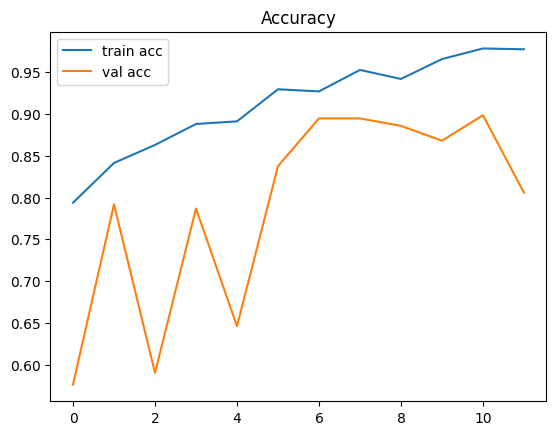

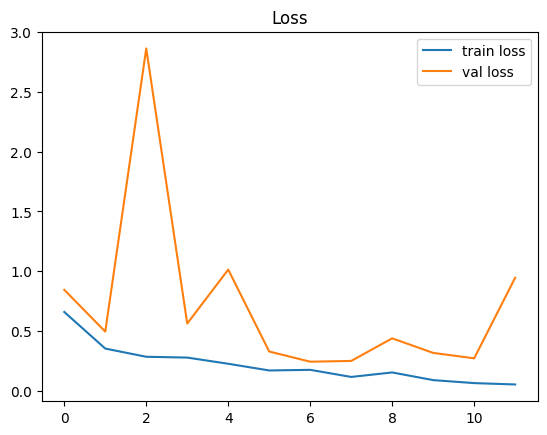

Confusion Matrix:
 [[305  32]
 [ 51 400]]

Classification Report:
               precision    recall  f1-score   support

      Benign       0.86      0.91      0.88       337
   Malignant       0.93      0.89      0.91       451

    accuracy                           0.89       788
   macro avg       0.89      0.90      0.89       788
weighted avg       0.90      0.89      0.89       788



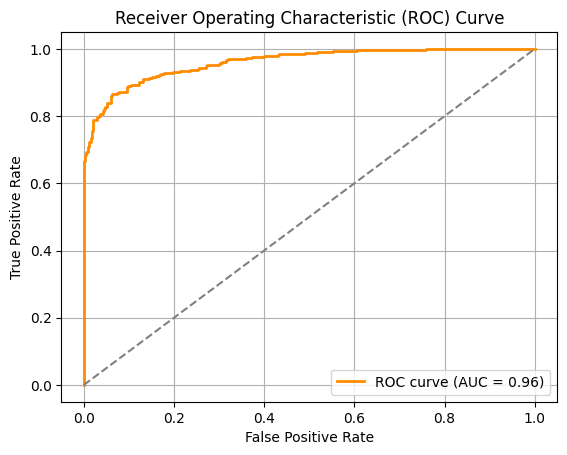

In [ ]:
# STEP 9: Plot Accuracy and Loss

# Predictions
y_pred_probs = model.predict([X_img_test, X_fd_test])
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Classification Report
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Benign", "Malignant"]))

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_probs[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# STEP 10: Save the Model
model.save("/content/drive/MyDrive/breast_cancer_dual_input_model.h5")
print("Model saved successfully!")

Model saved successfully!


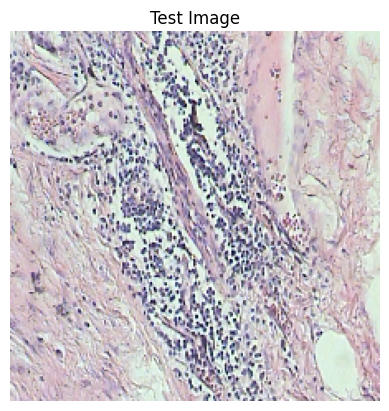

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
Prediction: Benign (98.51%)


In [ ]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import math

# Load the saved model
model = load_model("/content/drive/MyDrive/breast_cancer_dual_input_model.h5")

# Differential Box Counting for FD of the image
def differential_box_counting(grayscale_matrix):
    size_of_matrix = grayscale_matrix.shape[0]
    size_of_grid = 2
    num_of_boxes = []
    size_array = []

    while size_of_grid <= size_of_matrix // 2:
        ans = 0
        for i in range(0, size_of_matrix, size_of_grid):
            for j in range(0, size_of_matrix, size_of_grid):
                sub_mat = grayscale_matrix[i:i+size_of_grid, j:j+size_of_grid]
                if sub_mat.shape[0] != size_of_grid or sub_mat.shape[1] != size_of_grid:
                    continue
                max_gray = np.max(sub_mat)
                min_gray = np.min(sub_mat)
                delta = math.ceil(max_gray / size_of_grid) - math.ceil(min_gray / size_of_grid) + 1
                ans += delta
        num_of_boxes.append(ans)
        size_array.append(size_of_grid)
        size_of_grid *= 2

    if len(num_of_boxes) < 2:
        return 0.0

    x = np.log(np.array([size_of_matrix / s for s in size_array]))
    y = np.log(np.array(num_of_boxes))
    slope, _ = np.polyfit(x, y, 1)
    return -slope

# Function to preprocess and predict a single image
def predict_image(img_path):
    try:
        # Load and preprocess image
        img = load_img(img_path, target_size=(224, 224))
        plt.imshow(img)
        plt.title("Test Image")
        plt.axis('off')
        plt.show()

        img_arr = img_to_array(img) / 255.0
        img_arr = np.expand_dims(img_arr, axis=0)

        # Convert to grayscale and compute FD
        gray = cv2.cvtColor((img_arr[0] * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
        fd = differential_box_counting(gray)
        fd = np.array([[fd]])  # Shape: (1,1)

        # Predict
        prediction = model.predict([img_arr, fd])
        class_index = np.argmax(prediction)
        confidence = prediction[0][class_index]

        labels = ['Benign', 'Malignant']
        print(f"Prediction: {labels[class_index]} ({confidence*100:.2f}%)")
    except Exception as e:
        print(f"Error: {e}")

predict_image("/content/drive/MyDrive/SOB_B_TA-14-21978AB-100-011.png")